In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [7]:
#MSE sleap
import h5py
filename = '../tools/sleap_bottomup.slp'
with h5py.File(filename, 'r') as f:
    # List all groups
    print('Keys: %s' % f.keys())
    a_group_key = list(f.keys())
    print('a_group_key:', a_group_key)
    # Get the data
    frames = f['frames'][()]
    instances = f['instances'][()]
    points = f['points'][()]
    pred_points = f['pred_points'][()]
print(frames[0][4])
print(frames[1][4]-frames[1][3])
for f in frames:
    print('frames')
    print(f)
    
for f in instances:
    print('ints')
    print(f)
    
#for f in points:
print('ponts', points)
print(len(pred_points))
#print(f)
    
for i, f in enumerate(pred_points):
    print(i,' :pred pont')
    print(f)
    
print(frames[0][4])



Keys: <KeysViewHDF5 ['frames', 'instances', 'metadata', 'points', 'pred_points', 'suggestions_json', 'tracks_json', 'videos_json']>
a_group_key: ['frames', 'instances', 'metadata', 'points', 'pred_points', 'suggestions_json', 'tracks_json', 'videos_json']
20
14
frames
(0, 0, 0, 0, 20)
frames
(1, 0, 1, 20, 34)
frames
(2, 0, 2, 34, 45)
frames
(3, 0, 3, 45, 57)
frames
(4, 0, 4, 57, 69)
frames
(5, 0, 5, 69, 80)
frames
(6, 0, 6, 80, 94)
frames
(7, 0, 7, 94, 110)
frames
(8, 0, 8, 110, 126)
frames
(9, 0, 9, 126, 146)
frames
(10, 0, 10, 146, 156)
frames
(11, 0, 11, 156, 168)
frames
(12, 0, 12, 168, 185)
frames
(13, 0, 13, 185, 200)
frames
(14, 0, 14, 200, 221)
frames
(15, 0, 15, 221, 240)
frames
(16, 0, 16, 240, 260)
frames
(17, 0, 17, 260, 277)
frames
(18, 0, 18, 277, 295)
frames
(19, 0, 19, 295, 310)
frames
(20, 0, 20, 310, 326)
frames
(21, 0, 21, 326, 343)
frames
(22, 0, 22, 343, 358)
frames
(23, 0, 23, 358, 373)
frames
(24, 0, 24, 373, 390)
frames
(25, 0, 25, 390, 410)
frames
(26, 0, 26, 4

(387, 1, 24, 0, -1, -1, 6.7058077, 1935, 1940)
ints
(388, 1, 24, 0, -1, -1, 6.7306557, 1940, 1945)
ints
(389, 1, 24, 0, -1, -1, 5.9165354, 1945, 1950)
ints
(390, 1, 25, 0, -1, -1, 1.6876287, 1950, 1955)
ints
(391, 1, 25, 0, -1, -1, 7.0986958, 1955, 1960)
ints
(392, 1, 25, 0, -1, -1, 5.572201, 1960, 1965)
ints
(393, 1, 25, 0, -1, -1, 3.3964927, 1965, 1970)
ints
(394, 1, 25, 0, -1, -1, 7.064783, 1970, 1975)
ints
(395, 1, 25, 0, -1, -1, 7.4762797, 1975, 1980)
ints
(396, 1, 25, 0, -1, -1, 5.5982943, 1980, 1985)
ints
(397, 1, 25, 0, -1, -1, 8.062967, 1985, 1990)
ints
(398, 1, 25, 0, -1, -1, 6.813657, 1990, 1995)
ints
(399, 1, 25, 0, -1, -1, 6.814254, 1995, 2000)
ints
(400, 1, 25, 0, -1, -1, 7.104128, 2000, 2005)
ints
(401, 1, 25, 0, -1, -1, 6.883565, 2005, 2010)
ints
(402, 1, 25, 0, -1, -1, 5.244332, 2010, 2015)
ints
(403, 1, 25, 0, -1, -1, 6.879403, 2015, 2020)
ints
(404, 1, 25, 0, -1, -1, 6.180684, 2020, 2025)
ints
(405, 1, 25, 0, -1, -1, 7.76459, 2025, 2030)
ints
(406, 1, 25, 0, -1, -1, 

(1238.28491211, 48.06990814, True, False, 0.49068427)
284  :pred pont
(1295.95214844, 131.30357361, True, False, 0.40969831)
285  :pred pont
(1033.84875488, 16.50034904, True, False, 0.59236985)
286  :pred pont
(1103.46691895, 239.34973145, True, False, 0.89687437)
287  :pred pont
(1091.17456055, 144.44404602, True, False, 0.69447863)
288  :pred pont
(1068.09667969, 253.06506348, True, False, 0.64865345)
289  :pred pont
(1129.31384277, 252.48027039, True, False, 0.69576865)
290  :pred pont
(1620.24084473, 179.61051941, True, False, 0.93385023)
291  :pred pont
(nan, nan, True, False, 0.)
292  :pred pont
(1644.2791748, 34.80020142, True, False, 0.60818517)
293  :pred pont
(nan, nan, True, False, 0.)
294  :pred pont
(nan, nan, True, False, 0.)
295  :pred pont
(1151.90820312, 275.97207642, True, False, 1.02059531)
296  :pred pont
(1008.68475342, 442.48748779, True, False, 0.36494413)
297  :pred pont
(1057.83776855, 385.39190674, True, False, 0.58659172)
298  :pred pont
(nan, nan, True, Fal

(1094.22497559, 16.80922508, True, False, 0.43202385)
638  :pred pont
(nan, nan, True, False, 0.)
639  :pred pont
(nan, nan, True, False, 0.)
640  :pred pont
(504.53726196, 133.71737671, True, False, 0.79880148)
641  :pred pont
(nan, nan, True, False, 0.)
642  :pred pont
(515.50854492, 22.23918152, True, False, 0.45977965)
643  :pred pont
(nan, nan, True, False, 0.)
644  :pred pont
(nan, nan, True, False, 0.)
645  :pred pont
(1381.63818359, 203.02548218, True, False, 0.99839646)
646  :pred pont
(nan, nan, True, False, 0.)
647  :pred pont
(1283.77624512, 299.50915527, True, False, 0.70554149)
648  :pred pont
(nan, nan, True, False, 0.)
649  :pred pont
(nan, nan, True, False, 0.)
650  :pred pont
(1031.66149902, 227.55418396, True, False, 0.53430575)
651  :pred pont
(996.83996582, 23.88106728, True, False, 0.61959261)
652  :pred pont
(1021.03820801, 155.14849854, True, False, 0.55171919)
653  :pred pont
(1031.73132324, 18.15127754, True, False, 0.55698597)
654  :pred pont
(997.10656738, 1

(nan, nan, True, False, 0.)
996  :pred pont
(1260.69848633, 71.32306671, True, False, 0.84246475)
997  :pred pont
(1273.93310547, 9.88556671, True, False, 0.62689698)
998  :pred pont
(1211.84301758, 95.36582184, True, False, 0.72723532)
999  :pred pont
(1306.4876709, 120.73754883, True, False, 0.75724316)
1000  :pred pont
(551.7769165, 61.33349609, True, False, 0.73162794)
1001  :pred pont
(nan, nan, True, False, 0.)
1002  :pred pont
(624.28326416, 120.93771362, True, False, 0.63562483)
1003  :pred pont
(nan, nan, True, False, 0.)
1004  :pred pont
(nan, nan, True, False, 0.)
1005  :pred pont
(1944.72424316, 94.7068634, True, False, 0.98493958)
1006  :pred pont
(1848.50085449, 312.13717651, True, False, 0.99313992)
1007  :pred pont
(1871.61425781, 239.76956177, True, False, 0.90664029)
1008  :pred pont
(1787.59533691, 347.15750122, True, False, 1.05796874)
1009  :pred pont
(1906.37634277, 361.65335083, True, False, 0.7718755)
1010  :pred pont
(1571.62841797, 226.81230164, True, False, 0

(961.65551758, 887.02441406, True, False, 0.9703753)
1356  :pred pont
(1022.3605957, 647.37060547, True, False, 0.91172099)
1357  :pred pont
(1007.57232666, 719.66558838, True, False, 0.81876689)
1358  :pred pont
(1104.00244141, 614.14703369, True, False, 1.01646912)
1359  :pred pont
(1006.9899292, 566.27258301, True, False, 0.85953593)
1360  :pred pont
(553.58813477, 935.14996338, True, False, 0.75325024)
1361  :pred pont
(611.68078613, 1175.04858398, True, False, 0.91782302)
1362  :pred pont
(587.30285645, 1091.72412109, True, False, 0.76033419)
1363  :pred pont
(587.75457764, 1201.30554199, True, False, 0.58862525)
1364  :pred pont
(658.92681885, 1187.21948242, True, False, 0.67329121)
1365  :pred pont
(1427.53552246, 1055.35510254, True, False, 0.88693702)
1366  :pred pont
(1464.8302002, 793.69567871, True, False, 0.88696259)
1367  :pred pont
(1453.94909668, 865.22564697, True, False, 0.89187574)
1368  :pred pont
(1536.39685059, 768.11975098, True, False, 0.97783279)
1369  :pred po

(696.14782715, 1200.40087891, True, False, 0.77072769)
1712  :pred pont
(624.16833496, 1140.22924805, True, False, 0.7428984)
1713  :pred pont
(708.62402344, 1225.78369141, True, False, 0.48470467)
1714  :pred pont
(732.23468018, 1202.33862305, True, False, 0.47787148)
1715  :pred pont
(698.35308838, 17.85642242, True, False, 0.80398363)
1716  :pred pont
(635.65527344, 287.762146, True, False, 0.95627183)
1717  :pred pont
(658.94830322, 204.78315735, True, False, 0.8586998)
1718  :pred pont
(553.79382324, 301.71484375, True, False, 0.74559122)
1719  :pred pont
(672.59484863, 347.9793396, True, False, 0.81860018)
1720  :pred pont
(841.22247314, 120.79285431, True, False, 0.89327222)
1721  :pred pont
(826.94732666, 396.98684692, True, False, 0.93990701)
1722  :pred pont
(825.8918457, 323.5612793, True, False, 0.79984403)
1723  :pred pont
(767.38427734, 444.67181396, True, False, 0.89995766)
1724  :pred pont
(877.41369629, 444.69921875, True, False, 0.9730522)
1725  :pred pont
(325.118682

(552.50384521, 454.4909668, True, False, 0.90180147)
2068  :pred pont
(465.29150391, 526.9831543, True, False, 0.86392492)
2069  :pred pont
(552.6585083, 576.1395874, True, False, 0.55631149)
2070  :pred pont
(876.81884766, 383.12255859, True, False, 0.86762369)
2071  :pred pont
(828.97369385, 119.89099121, True, False, 0.89305741)
2072  :pred pont
(850.17498779, 204.51679993, True, False, 0.79886615)
2073  :pred pont
(854.41546631, 60.11651993, True, False, 0.84901124)
2074  :pred pont
(757.49786377, 73.7862854, True, False, 0.84939224)
2075  :pred pont
(1452.21838379, 469.23825073, True, False, 0.88710397)
2076  :pred pont
(1378.42907715, 719.93835449, True, False, 0.89066952)
2077  :pred pont
(1393.72363281, 649.54632568, True, False, 0.8908484)
2078  :pred pont
(1320.18359375, 744.87219238, True, False, 1.08904636)
2079  :pred pont
(1403.77770996, 780.46899414, True, False, 0.80257124)
2080  :pred pont
(1067.08850098, 503.16738892, True, False, 0.88837546)
2081  :pred pont
(1019.75

In [8]:
kps_bu = []#np.zeros((30))
for img_idx in range(0,30):
    if img_idx == 0:
        num_before = 0
        num_bees_per_img = frames[0][4]
    else:
        num_before = frames[(img_idx-1)][4]
        num_bees_per_img = frames[img_idx][4]-frames[img_idx][3]
    print("nb", num_before)
    print("num kps", int(num_bees_per_img*5))
    print("range", int(num_before*5+num_bees_per_img*5) - int(num_before*5))
    #kps[img_idx] = np.zeros((num_bees_per_img,5,2))
    kps_bu.append(np.zeros((num_bees_per_img,5,2)))
    counter = 0
    current_idx = int(num_before*5)
    for pred_bee in range(0,num_bees_per_img):
        for kpt in range(0,5):
    #for point in pred_points[int(num_before*5):int(num_before*5+num_bees_per_img*5)]:
            #print("point", point)
            x = pred_points[current_idx][0]
            y = pred_points[current_idx][1]
            kps_bu[img_idx][pred_bee][kpt][0] = x
            kps_bu[img_idx][pred_bee][kpt][1] = y
            current_idx = current_idx + 1
        #while
print("KPSSSS",kps_bu)


bboxes_bu = []

bees_in_imgs = []
for img_idx in range(0,30):
    if img_idx == 0:
        num_bees_per_img = frames[0][4]
        bees_in_imgs.append(num_bees_per_img)
    else:
        num_bees_per_img = frames[img_idx][4]-frames[img_idx][3]
        bees_in_imgs.append(num_bees_per_img)

for im_idx in range(0,30):
    bb_in_im = np.zeros((bees_in_imgs[im_idx],4))
    for bee in range(0, bees_in_imgs[im_idx]):
        bb_i = bounding_box(kps_bu[im_idx][bee])
        bb_in_im[bee] = bb_i
        #print("kps: ", kps_bu[im_idx][bee])
        #print("box: ", bb_i)
    bboxes_bu.append(bb_in_im)
    
print("BBOXESS: ",bboxes_bu)

nb 0
num kps 100
range 100
nb 20
num kps 70
range 70
nb 34
num kps 55
range 55
nb 45
num kps 60
range 60
nb 57
num kps 60
range 60
nb 69
num kps 55
range 55
nb 80
num kps 70
range 70
nb 94
num kps 80
range 80
nb 110
num kps 80
range 80
nb 126
num kps 100
range 100
nb 146
num kps 50
range 50
nb 156
num kps 60
range 60
nb 168
num kps 85
range 85
nb 185
num kps 75
range 75
nb 200
num kps 105
range 105
nb 221
num kps 95
range 95
nb 240
num kps 100
range 100
nb 260
num kps 85
range 85
nb 277
num kps 90
range 90
nb 295
num kps 75
range 75
nb 310
num kps 80
range 80
nb 326
num kps 85
range 85
nb 343
num kps 75
range 75
nb 358
num kps 75
range 75
nb 373
num kps 85
range 85
nb 390
num kps 100
range 100
nb 410
num kps 85
range 85
nb 427
num kps 80
range 80
nb 443
num kps 70
range 70
nb 457
num kps 50
range 50
KPSSSS [array([[[ 792.40716553,   10.64623165],
        [ 887.86669922,  181.61003113],
        [ 851.44158936,  106.54940796],
        [ 839.88604736,  227.22018433],
        [ 923.9432983

        [1308.38378906,  768.85198975]]])]
BBOXESS:  [array([[ 792.40716553,   10.64623165,  923.94329834,  227.22018433],
       [ 947.70294189,   10.31491566,  973.05096436,   72.96406555],
       [1247.8314209 ,   84.32096863, 1489.4909668 ,  216.92788696],
       [ 587.24316406,   17.52002144,  647.50390625,  133.14553833],
       [1500.04260254,  264.93191528, 1753.2668457 ,  469.59713745],
       [ 490.71438599,  286.84320068,  697.58868408,  564.71936035],
       [ 815.62542725,  263.75393677, 1115.95837402,  311.37741089],
       [1837.94958496,   34.9794426 , 1922.03723145,  312.82373047],
       [2232.17944336,   97.57376862, 2292.6496582 ,  383.9704895 ],
       [ 504.77069092,  588.21478271,  637.39526367,  779.50915527],
       [1127.38842773,  670.68273926, 1235.55969238,  973.8338623 ],
       [ 456.84628296,  780.31695557,  600.55645752, 1056.89489746],
       [1584.76660156,  551.70428467, 1645.98376465,  864.61419678],
       [ 683.66693115,  540.98370361,  790.166931

In [16]:
#single mse sleap bu
import matplotlib.gridspec as gridspec
from itertools import chain
import pdb


loss = "bottom_up"

mse_total = []
tim = [test_images[0]]
for idx, image in enumerate(tim):
#     if idx == 0:
#         num_bees_per_img = frames[0][4]
#     else:
#         num_bees_per_img = frames[idx][4]-frames[idx][3]
#     print("num_bees_in_img",num_bees_per_img)
    mse_per_bee = []
    kps = kps_bu[idx]
    bboxes = bboxes_bu[idx]
    
    #kps = tps.get_field("keypoints").keypoints
    #bboxes = tps.bbox
    #print(bbox)
    #print(kps)

    
    for p in data_an['images'][:]:
        if (str(p['file_name']) == test_files[idx] ):
            im_id = p['id']         
    print(im_id)
    for p in data_an['annotations'][:]:
        if ((p['image_id']) == im_id ):
            #print(p['id'])
            #bb = p["segmentation"]#p['bbox']
            bb = p['bbox']
            #bb = bb[0]
            print('bb', bb)
            bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
            print('bbf', bb_f)
            bbox = bounding_box(bb_f)
            cent_val = get_centroid(bbox)
            dists = []
            #print(cent_val)
            for index, p_bbox in enumerate(bboxes):
                if np.isnan(p_bbox).any() == False:
                    print("NOT NANNNNNN", p_bbox)
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                else:
                    dists.append(9999999)
                #print(dist)
            min_idx = dists.index(min(dists))
            #print("min id", min_idx)
            kps_val = p["keypoints"]
            print('kps val', kps_val)
            # comment for test and remove og
            #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
            #print('kps val', kps_val)
            kps_pred = kps[min_idx].tolist()
            kps_pred_list = [kps_pred[0],kps_pred[1],kps_pred[2],kps_pred[3],kps_pred[4]]
            kps_pl = list(chain.from_iterable(kps_pred_list))
            #print("kps val", kps_val)
            print("kp pred", kps_pred)
            print("kp pred listt", kps_pred_list)
            diff_vec = np.array(kps_val) - np.array(kps_pl)
            diff_vec = np.array([0 if math.isnan(x) else x for x in diff_vec])
            #print(diff_vec)
            #print(diff_vec*diff_vec)
            diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
            #print(diff_vec_sum_sq)
            if np.isnan(diff_vec_sum_sq):
                print("nan alert", diff_vec_sum_sq)
                print("diff_vec", diff_vec)
                print("kp pred listt", kps_pred_list)
                print('kps val', kps_val)
                pdb.set_trace()
            mse_per_bee.append(diff_vec_sum_sq)
        
    mse_per_image = sum(mse_per_bee)
    
        
    #print("mse", mse_per_image)
    #print("mse", mse_per_bee)
    mse_final = mse_per_image/len(mse_per_bee)
    mse_total.append(mse_final)
    #print("mse final", mse_final)
 

    #img3 = predictions[:, :, [2, 1, 0]]
    #b,g,r = cv2.split(img3)       # get b,g,r
    #img3 = cv2.merge([r,g,b])     # switch it to rgb
    #im = axes[idx][2].imshow(img3)
    #axes[idx][2].invert_yaxis()
    #plt.savefig(base_file + '_reg.png')
print("mse total for all images", mse_total)
print(sum(mse_total))
mse_test = sum(mse_total)/len(mse_total)
print("mse yo sleap bu", mse_test)


51501
bb [625.7417691078837, 229.806445285851, 462.65927639188794, 518.0452696210994, 614.1000838512198, 603.7288843678266, 772.2582308921163, 324.193554714149]
bbf [[625.7417691078837, 229.806445285851], [462.65927639188794, 518.0452696210994], [614.1000838512198, 603.7288843678266], [772.2582308921163, 324.193554714149]]
NOT NANNNNNN [792.40716553  10.64623165 923.94329834 227.22018433]
NOT NANNNNNN [947.70294189  10.31491566 973.05096436  72.96406555]
NOT NANNNNNN [1247.8314209    84.32096863 1489.4909668   216.92788696]
NOT NANNNNNN [587.24316406  17.52002144 647.50390625 133.14553833]
NOT NANNNNNN [1500.04260254  264.93191528 1753.2668457   469.59713745]
NOT NANNNNNN [490.71438599 286.84320068 697.58868408 564.71936035]
NOT NANNNNNN [ 815.62542725  263.75393677 1115.95837402  311.37741089]
NOT NANNNNNN [1837.94958496   34.9794426  1922.03723145  312.82373047]
NOT NANNNNNN [2232.17944336   97.57376862 2292.6496582   383.9704895 ]
NOT NANNNNNN [504.77069092 588.21478271 637.39526367

1 of 8: 100/0/standard 

In [68]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
version = "0"
#loss = "standard_small_lr_f75_1_2dl/0"
#loss = "standard_small_lr_.0001_f75_1_2dl/0"
#loss = "combined_small_lr_f25_.01_2dl/c0/.01"
#loss = "standard_small_lr_.00002_f90_1_2dl/0"
#loss = "combined_small_lr_f75_.01_.01_2dl/0"
#loss = "combined_small_lr_f75_.01_.001_2dl/0"
#loss = "combined_small_lr_f75_.001_.01_2dl/0"
#loss = "combined_small_lr_f75_.001_.001_2dl/0"
loss = "combined_test_lr_f75_.01.05_pfinal_v2/0"

config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0001000.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

coco_demo = COCODemo(
            cfg,
            min_image_size=800,
            confidence_threshold=0.2,
)


mse_total = []
tim = [test_images[0]]
for idx, image in enumerate(test_images):
    mse_per_bee = []
    predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
    kps = tps.get_field("keypoints").keypoints
    bboxes = tps.bbox
    #print("BBOXES", bboxes)
    #print("KPS",kps)
    plt.gca().invert_yaxis()
    imshow(predictions[:, :, [2, 1, 0]])
    plt.gca().invert_yaxis()
    
    for p in data_an['images'][:]:
        if (str(p['file_name']) == test_files[idx] ):
            im_id = p['id']         
    print(im_id)
    for p in data_an['annotations'][:]:
        if ((p['image_id']) == im_id ):
            #print(p['id'])
            #bb = p["segmentation"]#p['bbox']
            bb = p['bbox']
            #bb = bb[0]
            #print('bb', bb)
            bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
            #print('bbf', bb_f)
            bbox = bounding_box(bb_f)
            cent_val = get_centroid(bbox)
            dists = []
            #print(cent_val)
            for index, p_bbox in enumerate(bboxes):
                cp = get_centroid(p_bbox)
                dist = get_dist(cent_val, cp)
                dists.append(dist)
                #print(dist)
            min_idx = dists.index(min(dists))
            #print("min id", min_idx)
            kps_val = p["keypoints"]
            #print('kps val', kps_val)
            # comment for test and remove og
            #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
            #print('kps val', kps_val)
            kps_pred = kps[min_idx].tolist()
            kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
            kps_pl = list(chain.from_iterable(kps_pred_list))
            #print("kps val", kps_pred)
            #print("kp pred listt", kps_pred_list)
            diff_vec = np.array(kps_val) - np.array(kps_pl)
            #print(diff_vec)
            #print(diff_vec*diff_vec)
            diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
            #print(diff_vec_sum_sq)
            mse_per_bee.append(diff_vec_sum_sq)
        
    mse_per_image = sum(mse_per_bee)
    #print("mse", mse_per_image)
    #print("mse", mse_per_bee)
    mse_final = mse_per_image/len(mse_per_bee)
    mse_total.append(mse_final)
    #print("mse final", mse_final)
 

    #img3 = predictions[:, :, [2, 1, 0]]
    #b,g,r = cv2.split(img3)       # get b,g,r
    #img3 = cv2.merge([r,g,b])     # switch it to rgb
    #im = axes[idx][2].imshow(img3)
    #axes[idx][2].invert_yaxis()
    #plt.savefig(base_file + '_reg.png')
print("mse total for all images", mse_total)
print(sum(mse_total))
mse_test = sum(mse_total)/len(mse_total)
print("mse yo", mse_test)


FileNotFoundError: [Errno 2] No such file or directory: '/home/bsb2144/directpose/tools/training_dir/250/combined_test_lr_f75_.01.05_pfinal_v2/0/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0002500.pth'

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2169b064a8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
51501
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b20e4fd62e8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw re

now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=13, image_width=2560, image_height=1440, mode=xyxy)
52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b216e872828>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:


53857
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2161d99c18>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2161e88710>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T


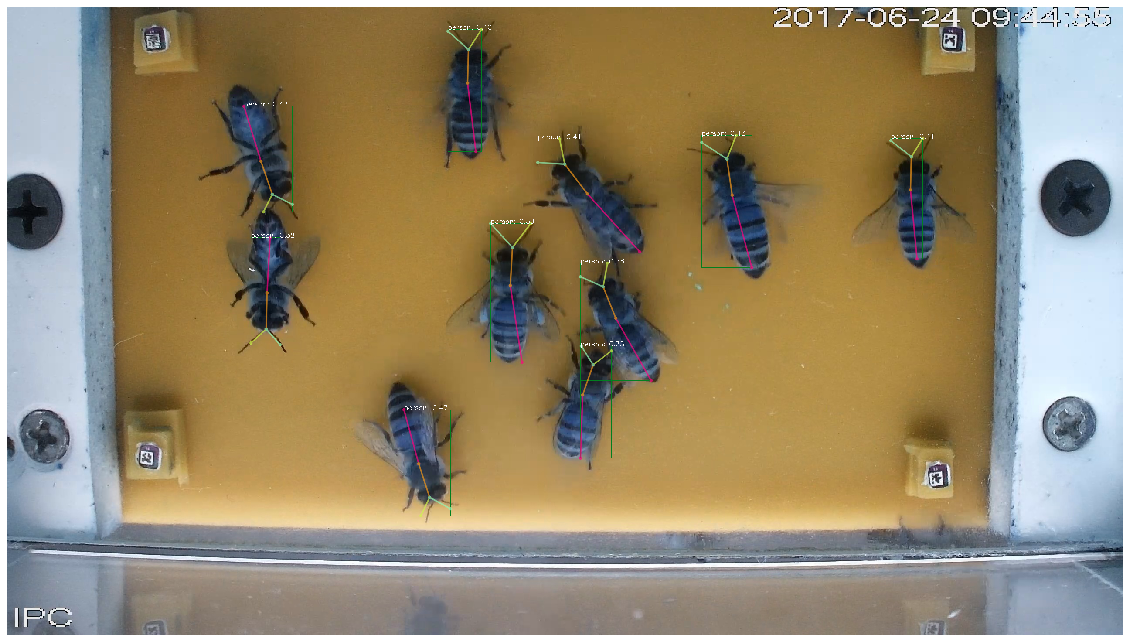

In [61]:
#The new losses

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]#"DP Predictions", "Combined Heatmap", "Combined Pred"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
versions = ["1"]#, "5", "6", "7"]#, "8", "9", "a", "b", "c", "d", "e", "f", "g", "h", "k", "m", "n", "p", "q"]#["0", "1", "2", "3"]
#loss = "combined_from_standard_nw"
#losses = ["combined_fs_nw_", "combined_fs_w_", "combined_fs_nw_avg", "combined_fs_w_avg"]
#losses = ["combined_fs_fw_vo"]#,"combined_fs_fc_un"]
#losses = ["combined_fsla_v2"]
losses = ["combined_fs_dl_test_v2", "combined_fs_dl_test_v2", "combined_fs_dl_test_v2", "combined_fs_dl_test_v2"]
#losses = ["combined_fs_wsamp_95"]#["combined_fs_test_dl"]#["combined_fs25k_v1"]
alphas = [".001"]#, ".001", ".1"]#, ".01", ".1"]#, ".5"]#, "1"]

test_losses = []

for (loss,version) in zip(losses,versions):
    for alpha in alphas:
        config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

        cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
        cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                             'DATATYPE', 'bee', \
                             'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss + '/'+ version + '/'+ alpha +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                             'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/'+ version + '/'+ alpha +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0002500.pth',\
                             'DATASETS.TEST', "('bee_val_cocostyle',)",\
                             'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                            ])

        coco_demo = COCODemo(
                    cfg,
                    min_image_size=800,
                    confidence_threshold=0.2,
        )


        plt.figure(figsize = (20,12))

        mse_total = []
        for idx, image in enumerate(test_images):
            mse_per_bee = []
            predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
            kps = tps.get_field("keypoints").keypoints
            bboxes = tps.bbox
            #print(bbox)
            #print(kps)
            plt.gca().invert_yaxis()
            imshow(predictions[:, :, [2, 1, 0]])
            plt.gca().invert_yaxis()

            for p in data_an['images'][:]:
                if (str(p['file_name']) == test_files[idx] ):
                    im_id = p['id']         
            print(im_id)
            for p in data_an['annotations'][:]:
                if ((p['image_id']) == im_id ):
                    #print(p['id'])
                    #bb = p["segmentation"]#p['bbox']
                    bb = p['bbox']
                    #bb = bb[0] #comment line for test
                    bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                    bbox = bounding_box(bb_f)
                    cent_val = get_centroid(bbox)
                    dists = []
                    #print(cent_val)
                    for index, p_bbox in enumerate(bboxes):
                        cp = get_centroid(p_bbox)
                        dist = get_dist(cent_val, cp)
                        dists.append(dist)
                        #print(dist)
                    min_idx = dists.index(min(dists))
                    #print("min id", min_idx)
                    kps_val = p["keypoints"]
                   # print('kps pre del', kps_valog)
                    #comment this line for test set
                    #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                    #kps_val = kps_val[!(2::3)] 
                    kps_pred = kps[min_idx].tolist()
                    kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                    kps_pl = list(chain.from_iterable(kps_pred_list))
                    #print("kps val", kps_val)
                    #print("kp pred", kps_pl)
                    diff_vec = np.array(kps_val) - np.array(kps_pl)
                    #print(diff_vec)
                    #print(diff_vec*diff_vec)
                    diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                    #print(diff_vec_sum_sq)
                    mse_per_bee.append(diff_vec_sum_sq)

            mse_per_image = sum(mse_per_bee)
            #print("mse", mse_per_image)
            #print("mse", mse_per_bee)
            mse_final = mse_per_image/len(mse_per_bee)
            mse_total.append(mse_final)
            #print("mse final", mse_final)


            #img3 = predictions[:, :, [2, 1, 0]]
            #b,g,r = cv2.split(img3)       # get b,g,r
            #img3 = cv2.merge([r,g,b])     # switch it to rgb
            #im = axes[idx][2].imshow(img3)
            #axes[idx][2].invert_yaxis()
            #plt.savefig(base_file + '_reg.png')
        #print("mse total for all images", mse_total)
        #print(sum(mse_total))
        mse_test = sum(mse_total)/len(mse_total)
        test_losses.append({loss+'/'+version+'/'+alpha : mse_test})
        #print("mse "+loss, mse_test)
        
print(test_losses)

In [ ]:
#big plot
import matplotlib.gridspec as gridspec

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]#"DP Predictions", "Combined Heatmap", "Combined Pred"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
version = "0"
#loss = "combined_from_standard_nw"
loss = "combined_fs_w_/.001"


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0002500.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

coco_demo = COCODemo(
            cfg,
            min_image_size=800,
            confidence_threshold=0.2,
)

plt.figure(figsize = (20,12))


for idx, image in enumerate(test_images):
    predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
    kps = tps.get_field("keypoints").keypoints
    bbox = tps.bbox
    print(bbox)
    print(kps)
    plt.gca().invert_yaxis()
    imshow(predictions[:, :, [2, 1, 0]])
    plt.gca().invert_yaxis()
    